In [1]:
import sys
sys.path.append('../../')

In [2]:

from config.constants import *
from backtesting import Backtest, Strategy
from backtesting.test import EURUSD, SMA 
from backtesting.lib import plot_heatmaps, resample_apply
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util.ATR import *
from util.plot_return import *

In [3]:
XAUUSD = {}
XAUUSD['H4'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H4'] + '.csv',index_col='Time',parse_dates=True)
XAUUSD['H1'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H1'] + '.csv', index_col='Time',parse_dates=True)

In [4]:
start_date = '2007-01-01'
end_date = '2008-01-01'

In [5]:
for i in TIMEFRAME :
    XAUUSD[i].index.name = None
    XAUUSD[i] = XAUUSD[i].loc[start_date:end_date]

In [4]:
XAUUSD['H4']

,Open,High,Low,Close,Volume
Time,,,,,
2007-01-01 00:00:00,635.679,636.194,635.009,635.497,95
2007-01-01 04:00:00,635.336,636.220,635.254,635.699,97
2007-01-01 08:00:00,635.780,636.225,635.201,635.993,99
2007-01-01 12:00:00,636.053,636.189,635.117,636.006,90
2007-01-01 16:00:00,635.902,636.185,635.006,635.989,96
...,...,...,...,...,...
2023-03-10 00:00:00,1831.428,1834.765,1827.974,1829.085,240
2023-03-10 04:00:00,1829.085,1834.575,1827.675,1833.405,240
2023-03-10 08:00:00,1833.415,1837.245,1830.778,1834.865,240


In [24]:
class Momentum(Strategy) :
    ATR_SL = 6
    max_dir_count = 2
    def init(self):
        self.data.df['ATR'] = ATR(self.data.df, 20)['ATR']
        self.data.df['direction'] = np.where(self.data.Close > self.data.Open, 'bull', 'bear')
        self.data.df['dir_count'] = self.data.df.groupby((self.data.df['direction'] != self.data.df['direction'].shift(1)).cumsum()).cumcount()+1
        
    

    def next(self):
        current_dir_count = self.data.df.loc[self.data.df.index[-1], 'dir_count']
        current_direction = self.data.df.loc[self.data.df.index[-1], 'direction']
        current_ATR = self.data.df.loc[self.data.df.index[-1], 'ATR']
        
        if current_dir_count >= self.max_dir_count and current_direction == 'bull' and not self.position and not np.isnan(current_ATR):
            if self.position.is_long :
                print('Have a order')
            tp = self.data.Close[-1] + current_ATR * self.ATR_SL
            sl = self.data.Open[-1]  - 0.001
              
                # Place your buy logic here
            
            self.buy(sl=sl, tp=tp, size= 20)
        if current_dir_count >= self.max_dir_count and current_direction == 'bear' and not self.position and not np.isnan(current_ATR):
            tp = self.data.Close[-1] - current_ATR * self.ATR_SL
            sl = self.data.Open[-1] + 0.001
               
            
           
            self.sell(sl=sl, tp=tp, size= 20)

In [6]:
account_size = 20000

In [25]:
bt = Backtest(XAUUSD['H4'], Momentum, cash=account_size, margin=1/2000, )
result = bt.run()
result

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   90.822298
Equity Final [$]                    72591.062
Equity Peak [$]                     73694.462
Return [%]                          262.95531
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                    6.653719
Volatility (Ann.) [%]               10.634673
Sharpe Ratio                         0.625663
Sortino Ratio                        1.068055
Calmar Ratio                         0.269253
Max. Drawdown [%]                  -24.711802
Avg. Drawdown [%]                   -1.118421
Max. Drawdown Duration      812 days 04:00:00
Avg. Drawdown Duration       18 days 20:00:00
# Trades                                 2157
Win Rate [%]                         11.49745
Best Trade [%]                      14.142366
Worst Trade [%]                     -5.204921
Avg. Trade [%]                    

In [20]:
result['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-10,21,21,626.772,628.917,-21.45,-0.003422,2007-01-04 12:00:00,2007-01-04 12:00:00,0 days 00:00:00
1,10,25,25,623.242,622.267,-9.75,-0.001564,2007-01-05 04:00:00,2007-01-05 04:00:00,0 days 00:00:00
2,10,26,26,623.648,623.241,-4.07,-0.000653,2007-01-05 08:00:00,2007-01-05 08:00:00,0 days 00:00:00
3,10,27,27,625.149,623.647,-15.02,-0.002403,2007-01-05 12:00:00,2007-01-05 12:00:00,0 days 00:00:00
4,10,32,32,608.366,607.807,-5.59,-0.000919,2007-01-08 04:00:00,2007-01-08 04:00:00,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...
2152,10,25830,25831,1872.665,1868.464,-42.01,-0.002243,2023-02-07 04:00:00,2023-02-07 08:00:00,0 days 04:00:00
2153,10,25836,25838,1876.275,1872.854,-34.21,-0.001823,2023-02-08 04:00:00,2023-02-08 12:00:00,0 days 08:00:00
2154,-10,25839,25841,1873.818,1880.156,-63.38,-0.003382,2023-02-08 16:00:00,2023-02-09 00:00:00,0 days 08:00:00
2155,10,25843,25844,1880.465,1878.614,-18.51,-0.000984,2023-02-09 08:00:00,2023-02-09 12:00:00,0 days 04:00:00


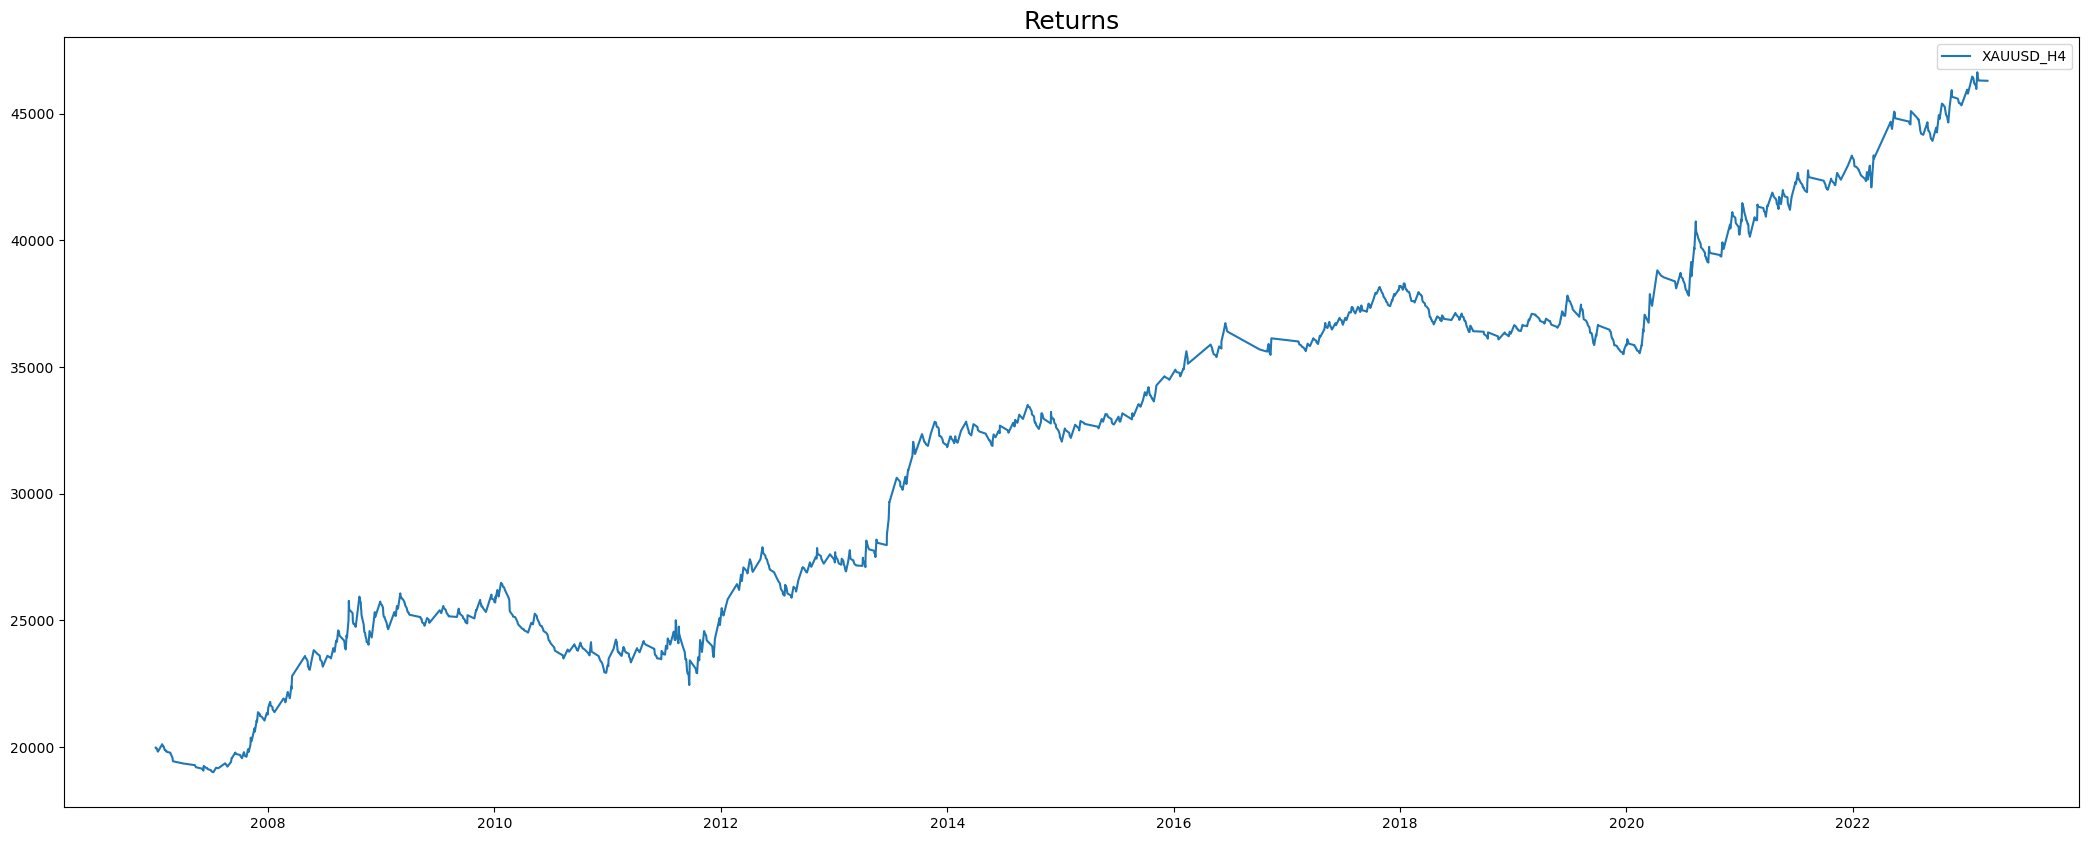

In [19]:
plot_return_trades(result['_trades'],'XAUUSD_H4',account_size)

In [13]:
bt.plot()

c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:119: UserWarning: Data contains too many candlesticks to plot; downsampling to '1D'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and w

Row(id='1407', ...)

Optimization

In [49]:
optimize, heatmap =  bt.optimize(
    ATR_SL = range(4,7,1),
    max_dir_count = range(2,5,1),
    maximize='Sharpe Ratio',
    return_heatmap= True,
    max_tries=10

)

  0%|          | 0/9 [00:00<?, ?it/s]

In [52]:
optimize

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   90.822298
Equity Final [$]                   22629.5531
Equity Peak [$]                    22684.7231
Return [%]                          13.147766
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                    0.619164
Volatility (Ann.) [%]                0.883748
Sharpe Ratio                         0.700611
Sortino Ratio                        1.122711
Calmar Ratio                         0.313243
Max. Drawdown [%]                   -1.976626
Avg. Drawdown [%]                   -0.112835
Max. Drawdown Duration      812 days 04:00:00
Avg. Drawdown Duration       18 days 20:00:00
# Trades                                 2157
Win Rate [%]                         11.49745
Best Trade [%]                      14.142366
Worst Trade [%]                     -5.204921
Avg. Trade [%]                    

In [54]:
optimize['_strategy']

<Strategy Momentum(ATR_SL=6,max_dir_count=2)>

In [55]:
heatmap

ATR_SL  max_dir_count
4       2                0.314321
        3                0.511507
        4                0.291337
5       2                0.313432
        3                0.564222
        4                0.104233
6       2                0.700611
        3                0.523300
        4                0.103268
Name: Sharpe Ratio, dtype: float64

In [52]:
hm = heatmap.groupby(["ATR_SL","max_dir_count"]).mean().unstack()

In [53]:
hm

max_dir_count,1,2,3,4,5,6,7,8,9
ATR_SL,,,,,,,,,
1,30.04335,31.9503,29.99210,29.99850,76.96435,71.03985,73.57730,88.7303,73.65
2,25.10570,28.5262,31.55560,40.33650,84.49030,138.01510,76.93780,98.7366,73.65
3,24.38755,25.0415,31.76570,146.96710,200.30615,145.42280,88.12370,98.8329,73.65
4,30.16000,28.0852,30.06660,227.31120,357.09120,98.19520,68.60980,108.7082,73.65
5,31.19450,20.6590,24.96550,323.67850,855.39275,154.34700,73.37575,118.7145,73.65
6,24.97670,23.2894,28.49540,380.07030,855.70270,174.37860,78.14170,67.6020,73.65
7,26.54480,24.1198,31.11230,797.14185,1299.18675,226.76385,51.69000,67.6020,73.65
8,30.55460,30.8062,31.63820,703.56760,951.85140,336.53640,51.69000,67.6020,73.65
9,26.67290,24.3056,32.03160,243.99975,730.04955,271.12905,51.69000,67.6020,73.65


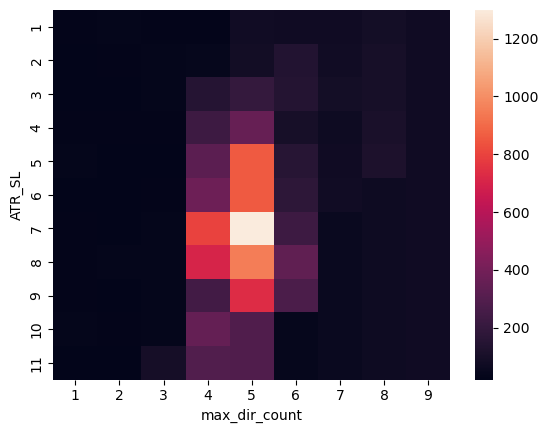

In [56]:
sns.heatmap(hm)
plt.show()

In [61]:
plot_heatmaps(heatmap, agg='mean',filename='../Strategy+8+-+Momentum.ipynb/Momentum_plot_heatmaps_.html')

Column(id='5715', ...)

In [31]:
bt.plot()

Row(id='4467', ...)